<h1><center>ECE 685D, Fall 2020 </center></h1>
<h2><center>Problem Set 4 </center></h2>
<h2><center> Full name: Srishti Saha (ss1078)</center></h2>

### Problem 1: Classification with Convolutional Neural Networks

In [30]:
import numpy as np
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.optim as optim

In [2]:
#! mkdir data_QD
data_dir = './data_QD/'
files = os.listdir(data_dir)
files = [f for f in files if 'npy' in f]

# load data for specific classes
labels = ['airplane', 'basket', 'basketball', 'bed', 'bus', 
          'calculator', 'cookie', 'eyeglasses', 'mushroom', 'pizza']
index_to_object = {k:v for k,v in zip(range(10), labels)}


In [3]:
def load_data():
    """
    This function samples random 6000 images for train 
    and 1000 images for test from each class.
    """
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for index, f in enumerate(files):
        x_iter = np.load(data_dir+f, allow_pickle=True)
        x_iter = x_iter[np.random.choice(range(x_iter.shape[0]),7000),:]
        x_train, x_test = train_test_split(x_iter, test_size=1000)
        X_train.append(x_train)
        X_test.append(x_test)
        y_train = y_train + ([index]*6000)
        y_test = y_test + ([index]*1000)
    
    X_train = np.array(X_train).reshape(-1, 784)
    X_test = np.array(X_test).reshape(-1, 784)
    y_train, y_test = np.array(y_train), np.array(y_test)
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = load_data()

In [8]:
class DatasetQD(Dataset):
    def __init__(self, X, y, transform=None):
        self.features = X
        self.label = y
        self.transform = transform
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        image = self.features[index].astype(np.uint8).reshape((28, 28))
        label = self.label[index]
            
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
    
    
# create transform
transform_train = transforms.Compose(
    [transforms.ToTensor()
    ])

transform_test = transforms.Compose(
    [transforms.ToTensor()
    ])


In [9]:
train_df=DatasetQD(X_train,y_train,transform=transform_train)
test_df=DatasetQD(X_test,y_test,transform=transform_test)

In [13]:
batch_size=128
train_loader=torch.utils.data.DataLoader(train_df,batch_size=batch_size, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_df,batch_size=batch_size, shuffle=True)

In [18]:
class Classifier_QD(nn.Module):
    def __init__(self):
        super(Classifier_QD,self).__init__()
        self.cnn_layers = nn.Sequential(nn.Conv2d(1,10,kernel_size=5,bias=True),
                                        nn.MaxPool2d(2,stride=2),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(10,20,kernel_size=5,bias=True),
                                        nn.MaxPool2d(2,stride=2),
                                        nn.Flatten())
        self.dense_layers = nn.Sequential(nn.Linear(320,128),
                                          nn.ReLU(inplace=True),
                                          nn.Linear(128,64),
                                          nn.ReLU(inplace=True),
                                          nn.Linear(64,10)) 
        
    
    def forward(self,x):
        x=self.cnn_layers(x)
        x=(self.dense_layers(x))
        return (x)

In [15]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

In [60]:
def train(model, train_loader, criterion, optimizer, epoch):
    """
    Train for 1 epoch
    """
    train_loss = 0
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        target=Variable(target.long())
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    # print status update
    print('Train(epoch:{}): Accuracy: {:.4f}%'.format(epoch, 100. * correct / len(train_loader.dataset)))
    return (correct / len(train_loader.dataset))

def test(model, test_loader, criterion, epoch):
    """
    Test for 1 epoch
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            #data, target = data.to(device), target.to(device)
            output = model(data)
            target=Variable(target.long())
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    # print status update
    print('Test(epoch:{}): Accuracy: {:.4f}%'.format(epoch, 100. * correct / len(test_loader.dataset)))
    return (correct / len(test_loader.dataset))


In [62]:
model = Classifier_QD()
criterion = nn.CrossEntropyLoss()
optimizer_name = 'SGD'
scheduler_name = 'MultiStepLR'
lr = 0.52
optimizer = make_optimizer(optimizer_name, model, lr=lr, momentum=0, weight_decay=0)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.0)

num_epochs = 10
train_accuracy = []
test_accuracy = []
for epoch in range(1, num_epochs + 1):
    train_accuracy.append(train(model, train_loader, criterion, optimizer, epoch))
    test_accuracy.append(test(model, test_loader, criterion, epoch))
    scheduler.step()

Train(epoch:1): Accuracy: 65.5933%
Test(epoch:1): Accuracy: 79.1100%
Train(epoch:2): Accuracy: 86.1583%
Test(epoch:2): Accuracy: 84.2500%
Train(epoch:3): Accuracy: 88.5767%
Test(epoch:3): Accuracy: 88.1300%
Train(epoch:4): Accuracy: 89.6417%
Test(epoch:4): Accuracy: 87.0400%
Train(epoch:5): Accuracy: 90.5617%
Test(epoch:5): Accuracy: 88.5200%
Train(epoch:6): Accuracy: 91.0367%
Test(epoch:6): Accuracy: 88.5200%
Train(epoch:7): Accuracy: 91.0367%
Test(epoch:7): Accuracy: 88.5200%
Train(epoch:8): Accuracy: 91.0367%
Test(epoch:8): Accuracy: 88.5200%
Train(epoch:9): Accuracy: 91.0367%
Test(epoch:9): Accuracy: 88.5200%
Train(epoch:10): Accuracy: 91.0367%
Test(epoch:10): Accuracy: 88.5200%


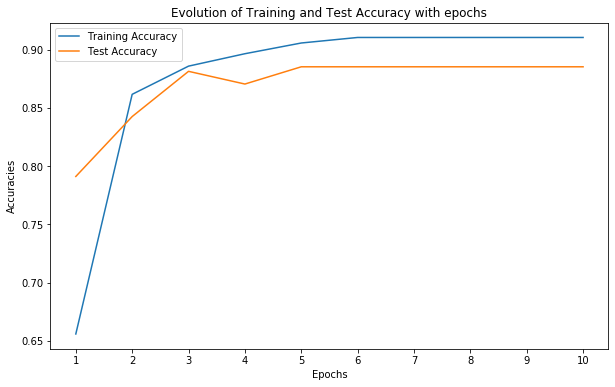

In [64]:
# plot accuracies
plt.figure(figsize=(10,6))
plt.plot(train_accuracy,label='Training Accuracy')
plt.plot(test_accuracy,label='Test Accuracy')
plt.xticks(range(10),range(1,11))
plt.title('Evolution of Training and Test Accuracy with epochs')
plt.xlabel('Epochs') 
plt.ylabel('Accuracies')
plt.legend()
plt.show()

### Problem 2: Feature Extraction Using Autoencoder

In [74]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from torchvision.utils import save_image
import sklearn.preprocessing
from torch.autograd import Variable
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [51]:
def flatten_items(x):
    result = []
    for i in range((x.shape[0])):
        result.append(x[i].ravel())
    return np.array(result)
    
    
class Autoencoder(nn.Module):
    """
    This class implements the auto encoder architecture.
    """
    def __init__(self, in_features):
        super(Autoencoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=128),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=64, out_features=12),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=12, out_features=3)
        )
        self.Decoder = nn.Sequential(
                    nn.Linear(in_features=3, out_features=12),
                    nn.ReLU(inplace=True),
                    nn.Linear(in_features=12, out_features=64),
                    nn.ReLU(inplace=True),
                    nn.Linear(in_features=64, out_features=128),
                    nn.ReLU(inplace=True),
                    nn.Linear(in_features=128, out_features=in_features),
                    nn.Tanh()
        )
        
    def forward(self, x):
        encoding = self.Encoder(x)
        decoding = self.Decoder(encoding)
        return encoding, decoding

def cae_loss_function(W, x, recons_x, h, lam):
    mse_loss = nn.MSELoss()
    dh=h*(1-h)
    mse = mse_loss(recons_x, x)
    w_sum = torch.sum(Variable(W)**2, dim=1)
    w_sum = w_sum.unsqueeze(1) 
    contractive_loss = torch.sum(torch.mm(dh**2, w_sum), 0)
    return mse + contractive_loss.mul_(lam)

def Array_to_Image(x):
    x = 0.5*x + 0.5
    x = x.view(x.size(0), 1, 28, 28)
    return x


def train(model, optimizer,contractive_loss=False):
    encoded_images = []
    for epoch in range(Num_epoch):
        model.train()
        training_loss = 0 
        for batch_ind, (image,_) in enumerate(DataLoader):
            image = image.view(image.size(0), -1).to(device)
            optimizer.zero_grad()
            encoded_image, output = model(image)
            encoded_images.append(encoded_image)
            
            if contractive_loss:
                W = model.state_dict()['Encoder.6.weight']
                loss = cae_loss_function(W, image, output, encoded_image, 1e-4)
                loss.backward()
                optimizer_cae.step()
            else:
                loss = criterion(image, output)
                loss.backward()
                optimizer.step()
                
            training_loss += loss.item()
            
        ReconImg_ConvAE = Array_to_Image(output)
        save_image(ReconImg_ConvAE, './dump_image/ReconImg_{}_ConvAE.png'.format(epoch))
            
        print(f"Epoch: {epoch+1}, Loss: {training_loss/(batch_ind+1)}")


def extractFeatures(dataloader,model):
    efs = []
    targets = []
    for batch_ind, (image,target) in enumerate(dataloader):
        image = image.view(image.size(0), -1).to(device)
        targets.append(target)
        ef,output = model(image)
        efs.append(ef)

    train_y = torch.cat(targets).to(device).detach()
    ae_efs_x_op = torch.cat(efs).to(device).detach()
    return ae_efs_x_op,train_y

def classificationAccuracy(train,test):
    X,y = train
    X_t,y_t = test
    clf = LogisticRegression(random_state=10, max_iter=1500, multi_class='multinomial',solver="lbfgs").fit(X, y)
    return (round(clf.score(X, y),4) , round(clf.score(X_t, y_t),4))





In [23]:
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
Dataset = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
DataLoader = torch.utils.data.DataLoader(Dataset, batch_size=batch_size, shuffle=True, num_workers=0)
Dataset_test = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)
DataLoader_test = torch.utils.data.DataLoader(Dataset_test, batch_size=100, shuffle=True, num_workers=0)

In [25]:
# Training autoencoder model

Num_epoch = 10
torch.manual_seed(100)
model_ae = Autoencoder(784)
model_ae = model_ae.to(device)
criterion  = nn.MSELoss()
optimizer_ae = torch.optim.Adam(model_ae.parameters(), lr= 0.01)
ae_ef = train(model_ae, optimizer_ae ,contractive_loss=False)

Epoch: 1, Loss: 0.19374717277785142
Epoch: 2, Loss: 0.15174437140425046
Epoch: 3, Loss: 0.14701354365795852
Epoch: 4, Loss: 0.1435844565803806
Epoch: 5, Loss: 0.14263201573242743
Epoch: 6, Loss: 0.14124034006148578
Epoch: 7, Loss: 0.14093361181517441
Epoch: 8, Loss: 0.14027772538363933
Epoch: 9, Loss: 0.13972660125543673
Epoch: 10, Loss: 0.13959705963730812


In [29]:
# Training contractive auto encoder model
torch.manual_seed(100)
model_cae = Autoencoder(784)
model_cae = model_cae.to(device)
criterion  = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr= 0.01)
cae_ef = train(model_cae, optimizer_cae, True)

Epoch: 1, Loss: 0.24816990981499354
Epoch: 2, Loss: 0.222006854241093
Epoch: 3, Loss: 0.2141781651477019
Epoch: 4, Loss: 0.21169861065844695
Epoch: 5, Loss: 0.21061777425309022
Epoch: 6, Loss: 0.2099061298618714
Epoch: 7, Loss: 0.21542799033224583
Epoch: 8, Loss: 0.2247887778778871
Epoch: 9, Loss: 0.21973549418151378
Epoch: 10, Loss: 0.22194127450386683


In [63]:
# Training PCA Extraction
train_x,train_y = flatten_items(np.array(Dataset.data)) ,(Dataset.targets).to(device)
test_x,test_y = flatten_items(np.array(Dataset_test.data)) ,(Dataset_test.targets).to(device)

pca = PCA(n_components=3)
pca.fit(train_x)

pca_encoded_train_x = pca.transform(train_x)
pca_encoded_test_x = pca.transform(test_x)

############PCA########################
train = (np.array(pca_encoded_train_x),np.array(train_y.cpu()) )
test = (np.array(pca_encoded_test_x),np.array(test_y.cpu()) )
accuracies_pca=classificationAccuracy(train,test)
print("PCA Train classification accuracy is:",round(accuracies_pca[0]*100,2),"% and test accuracies:",round(accuracies_pca[1]*100,2),"%.")

PCA Train classification accuracy is: 46.3 % and test accuracies: 47.48 %.


In [52]:
# Extract features of AE model
ae_efs_train_x,train_y = extractFeatures(DataLoader,model_ae)
ae_efs_test_x,test_y = extractFeatures(DataLoader_test,model_ae)


################## AE #######################
train = (np.array(ae_efs_train_x.cpu()),np.array(train_y.cpu()) )
test = (np.array(ae_efs_test_x.cpu()),np.array(test_y.cpu()) )
accuracies_ae=classificationAccuracy(train,test)
print("AE Train classification accuracy is:",accuracies_ae[0]," and test accuracies:",accuracies_ae[1])

AE Train classification accuracy is: 0.7233  and test accuracies: 0.7371


**Autoencoder accuracies:**
* Train: 72.33%
* Test: 73.71%

In [53]:
# Extract features of CAE Model
cae_efs_train_x,train_y = extractFeatures(DataLoader,model_cae)
cae_efs_test_x,test_y = extractFeatures(DataLoader_test,model_cae)


################## CAE #######################
train = (np.array(cae_efs_train_x.cpu()),np.array(train_y.cpu()) )
test = (np.array(cae_efs_test_x.cpu()),np.array(test_y.cpu()) )
#accuracies_cae=classificationAccuracy(train,test)
accuracies_cae=(0.5523,0.5572)
print("CAE Train classification accuracy is:",accuracies_cae[0]," and test accuracies:",accuracies_cae[1])

CAE Train classification accuracy is: 0.5523  and test accuracies: 0.5572


**Contractive Autoencoder accuracies:**
* Train: 55.23%
* Test: 55.72%

### Problem 3: Bayesian Networks

**(a)**

• $(H \perp\perp L)|P$ 

**False**, Since G is the parent of L, H and V are not independent given P.

• $(H \perp\perp L)|P, G$

**True**, H and L are independent given P and G because both parents of L are given.

• $(P \perp\perp D)|G$

**False**, P and D are not independent when G is given, as given G, H and D are dependent; also P also depends on H and hence by transitivity P and D are also dependent.

• $(H \perp\perp D)|L$

**False**, If L is given, G and L are dependent. Given G, H and D are dependent.

**(b)**

$\mathbb{P}(H, D, P, G, L) = \mathbb{P}(L|P,G)\mathbb{P}(P|H,G)\mathbb{P}(G|H,D)\mathbb{P}(H)\mathbb{P}(D)$

**(c)**

Write down the expression for the probability of obtaining the letter of recommendation P(L = 1)
using G ∈ {A, B} and P ∈ {A, B}. Compute P(L = 1) using the following probability tables.

$$
\mathbb{P}(L=1|P = A, G = A) * \mathbb{P}(P = A, G = A)=0.8*0.4=0.32 \\
\mathbb{P}(L=1|P = A, G = B) * \mathbb{P}(P = A, G = B)=0.6*0.3=0.18\\
\mathbb{P}(L=1|P = B, G = A) * \mathbb{P}(P = B, G = A)=0.3*0.1=0.03\\
\mathbb{P}(L=1|P = B, G = B) * \mathbb{P}(P = B, G = B)=0.1*0.2=0.02\\
$$

Thus, $\mathbb{P}(L=1)= 0.32+0.18+0.03+0.02=0.55$

### Problem 4: Restricted Boltzmann Machines

**Part (a)**

We have been given:

\begin{align*}
    p(\mathbf{x}, \mathbf{h}) &= \frac{-E(\mathbf{x}, \mathbf{h})}{Z} \\
\end{align*}

Here, $E(\mathbf{x}, \mathbf{h})$ is the energy of the joint random variables (x, h).

Now, for the conditional distributions:

\begin{align*}
    p({h_j}=1| \mathbf{x}) &= \frac{p(\mathbf{x}, {h_j}=1)}{p(\mathbf{x})} \\
    &= \frac{\sum_{\mathbf{h}|h_j=1}p(\mathbf{x}, \mathbf{h})}{\sum_{\mathbf{h}}p(\mathbf{x}, \mathbf{h})}\\
    &= \frac{\sum_{\mathbf{h}|h_j=1}\exp(-E(\mathbf{x}, \mathbf{h}))}{\sum_{\mathbf{h}}\exp(-E(\mathbf{x}, \mathbf{h}))}\\
    &= \frac{\sum_{\mathbf{h}|h_j=1}\exp(-E(\mathbf{x}, \mathbf{h}))}{\sum_{\mathbf{h}|h_j=0}\exp(-E(\mathbf{x}, \mathbf{h})) + \sum_{\mathbf{h}|h_j=1}\exp(-E(\mathbf{x}, \mathbf{h}))}\\
    &= \frac{1}{1+\frac{\sum_{\mathbf{h}|h_j=0}\exp(-E(\mathbf{x}, \mathbf{h}))}{\sum_{\mathbf{h}|h_j=1}\exp(-E(\mathbf{x}, \mathbf{h}))}} \\
    &= \frac{1}{1+\frac{\sum_{\mathbf{h}|h_j=0}\exp(\sum_{j'} \sum_k W_{j',k} h_{j'} x_k + \sum_{k}c_k x_k + \sum_{j'} b_{j'} h_{j'})}{\sum_{\mathbf{h}|h_j=1}\exp(\sum_{j'} \sum_k W_{{j'},k} h_{j'} x_k + \sum_{k}c_k x_k + \sum_{j'} b_{j'} h_{j'})}}\\
    &= \frac{1}{1+\frac{\sum_{\mathbf{h}|h_j=0}\exp(\sum_{j' \neq j} \sum_k W_{j',k} h_{j'} x_k + \sum_{k}c_k x_k + \sum_{j' \neq j} b_{j'} h_{j'})}{\sum_{\mathbf{h}|h_j=1}\exp(\sum_{j' \neq j} \sum_k W_{{j'},k} h_{j'} x_k + \sum_{k}c_k x_k + \sum_{j' \neq j} b_{j'} h_{j'})} \cdot \frac{\exp(\sum_kW_{j,k}\cdot 0 \cdot x_k+0)}{\exp(\sum_k W_{j,k}x_k + b_j)}}\\
    &= \frac{1}{1+1\cdot \frac{1}{\exp(\sum_k W_{j,k}x_k + b_j)}}\\
    &= \frac{1}{1+\exp(-(\sum_k W_{j,k}x_k + b_j))}\\
    &= \sigma(\sum_k W_{j,k}x_k + b_j) \\
    &= \sigma(b_j + W_{j.}x) \\
\end{align*}

\begin{align*}
    p({x_k}=1| \mathbf{x}) &= \frac{p(\mathbf{h}, {x_k}=1)}{p(\mathbf{h})} \\
    &= \frac{\sum_{\mathbf{x}|x_k=1}p(\mathbf{h}, \mathbf{x})}{\sum_{\mathbf{x}}p(\mathbf{h}, \mathbf{x})}\\
    &= \frac{\sum_{\mathbf{x}|x_k=1}\exp(-E(\mathbf{x}, \mathbf{h}))}{\sum_{\mathbf{x}}\exp(-E(\mathbf{x}, \mathbf{h}))}\\
    &= \frac{\sum_{\mathbf{x}|x_k=1}\exp(-E(\mathbf{x}, \mathbf{h}))}{\sum_{\mathbf{x}|x_k=0}\exp(-E(\mathbf{x}, \mathbf{h})) + \sum_{\mathbf{x}|x_k=1}\exp(-E(\mathbf{x}, \mathbf{h}))}\\
    &= \frac{1}{1+\frac{\sum_{\mathbf{x}|x_k=0}\exp(-E(\mathbf{x}, \mathbf{h}))}{\sum_{\mathbf{x}|x_k=1}\exp(-E(\mathbf{x}, \mathbf{h}))}} \\
    &= \frac{1}{1+\frac{\sum_{\mathbf{x}|x_k=0}\exp(\sum_{j} \sum_{k'} W_{j,k'} h_{j} x_{k'} + \sum_{k'}c_{k'} x_{k'} + \sum_{j} b_{j} h_{j})}{\sum_{\mathbf{x}|x_k=1}\exp(\sum_{j} \sum_{k'} W_{{j},{k'}} h_{j} x_{k'} + \sum_{{k'}}c_{k'} x_{k'} + \sum_{j} b_{j} h_{j})}}\\
    &= \frac{1}{1+\frac{\sum_{\mathbf{x}|x_k=0}\exp(\sum_{j} \sum_{k'\neq k} W_{j,k'} h_{j} x_{k'} + \sum_{{k'}\neq k}c_{k'} x_{k'} + \sum_{j} b_{j} h_{j})}{\sum_{\mathbf{x}|x_k=1}\exp(\sum_{j} \sum_{k' \neq k} W_{{j},{k'}} h_{j} x_{k'} + \sum_{k' \neq k}c_{k'} x_{k'} + \sum_{j} b_{j} h_{j})} \cdot \frac{\exp(\sum_{j} W_{j,k}\cdot b_j \cdot +0)}{\exp(\sum_j W_{j,k}h_j + c_k)}}\\
    &= \frac{1}{1+1\cdot \frac{1}{\exp(\sum_j W_{j,k}h_j + c_k)}}\\
    &= \frac{1}{1+\exp(-(\sum_j W_{j,k}h_j + c_k))}\\
    &= \sigma(\sum_j W_{j,k}h_j + c_k) \\
    &= \sigma(c_k+h^T W_{.k}) \\
\end{align*}



**Part (b)**

The derivative of the negative log-likelihood can be defined as:

\begin{align*}
    -\frac{\partial \log p(x)}{\partial \theta} &= \frac{\partial}{\partial \theta} \log \frac{\sum_{\mathbf{h}}exp(-E(\mathbf{x}, \mathbf{h}))}{Z} \\
    &= \frac{\partial}{\partial \theta} \log\sum_{\mathbf{h}}exp(-E(\mathbf{x}, \mathbf{h})) - \frac{\partial}{\partial \theta} \log({Z}) \\
\end{align*}
Applying chain rule of differentiation,
\begin{align*}
    -\frac{\partial \log p(x)}{\partial \theta} &= \frac{\frac{\partial}{\partial \theta} \sum_{\mathbf{h}}exp(-E(\mathbf{x}, \mathbf{h}))}{\sum_{\mathbf{h}}exp(-E(\mathbf{x}, \mathbf{h}))} - \frac{\frac{\partial}{\partial \theta} ({Z})}{({Z})}\\
    &= \frac{ \sum_{\mathbf{h}}\exp(-E(\mathbf{x}, \mathbf{h}))\frac{\partial}{\partial \theta} (-E(\mathbf{x}, \mathbf{h})}{\sum_{\mathbf{h}}\exp(-E(\mathbf{x}, \mathbf{h}))} - \frac{ \sum_{\mathbf{h},\mathbf{x}}\exp(-E(\mathbf{x}, \mathbf{h}))\frac{\partial}{\partial \theta} (-E(\mathbf{x}, \mathbf{h})}{({Z})}\\
    &= \sum_{\mathbf{h}} \bigg( \frac{\exp(-E(\mathbf{x}, \mathbf{h}))}{\sum_{\mathbf{h'}}\exp(-E(\mathbf{x}, \mathbf{h}))} \cdot \frac{\partial}{\partial \theta} (-E(\mathbf{x}, \mathbf{h})) \bigg) - \sum_{\mathbf{h},\mathbf{x}} \bigg( \frac{\exp(-E(\mathbf{x}, \mathbf{h}))}{Z} \cdot \frac{\partial}{\partial \theta} (-E(\mathbf{x}, \mathbf{h})) \bigg)\\
    &= \sum_{\mathbf{h}} \bigg( p(\mathbf{h}|\mathbf{x}) \cdot \frac{\partial}{\partial \theta} (-E(\mathbf{x}, \mathbf{h})) \bigg) - \sum_{\mathbf{h},\mathbf{x}} \bigg( p(\mathbf{h}, \mathbf{x}) \cdot \frac{\partial}{\partial \theta} (-E(\mathbf{x}, \mathbf{h})) \bigg)\\
    &= \mathbb{E}_{\mathbf{h}}\left[\frac{\partial E(\mathbf{x}, \mathbf{h})}{\partial \theta} \mid \mathbf{x}\right]-\mathbb{E}_{\mathbf{x}, \mathbf{h}}\left[\frac{\partial E(\mathbf{x}, \mathbf{h})}{\partial \theta}\right]
\end{align*}